In [2]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import pyasn
import requests
from mpl_toolkits.basemap import Basemap
import time
import json

from colors import Colors

%matplotlib inline

In [3]:
connection = sq.connect("./measurements-all.db")
connection.row_factory = sq.Row

In [40]:
def getRCodesForProtocolWithNull(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming AND {}.created < 1624485600".format(protocol, protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT ip, port, protocol, r_code FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND created < 1624485600
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND (measurement.ip, measurement.port) IN (SELECT ip, port FROM dns_measurements temp WHERE temp.protocol = '{}' AND temp.response_ip IS NOT NULL AND NOT temp.cache_warming AND temp.created < 1624485600);
    """.format(protocol, *statements.values(), protocol)
    df = pd.read_sql_query(sql, connection)
    return df

def getErrorSuccessCountForProtocol():
    udp = getRCodesForProtocolWithNull("udp")
    tcp = getRCodesForProtocolWithNull("tcp")
    tls = getRCodesForProtocolWithNull("tls")
    https = getRCodesForProtocolWithNull("https")
    quic = getRCodesForProtocolWithNull("quic")
    grouped = pd.concat([quic, https, tls, tcp, udp])
    result = { "status": ["success", "error", "error_rate"] }
    for key in grouped["protocol"].unique():
        filtered = grouped[grouped["protocol"] == key]
        success = (len(filtered.index) - filtered["r_code"].isna().sum(axis = 0)).item()
        error = filtered["r_code"].isna().sum(axis = 0).item()
        errorRate = error / len(filtered.index)
        result[key] = [success, error, errorRate]
    return pd.DataFrame(result)

def getRCodesForProtocol(protocol, rcodeNull = False, firstWeek = False):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming {}".format(protocol, protocol, protocol, protocol, protocol, "AND created < 1624485600" if firstWeek else "")
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT ip, port, protocol, r_code FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' {} {}
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({});
    """.format(protocol, "AND measurement.r_code IS NOT NULL" if not rcodeNull else "", "AND created < 1624485600" if firstWeek else "", *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getRCodesGroupedWithNull():
    udp = getRCodesForProtocolWithNull("udp")
    tcp = getRCodesForProtocolWithNull("tcp")
    tls = getRCodesForProtocolWithNull("tls")
    https = getRCodesForProtocolWithNull("https")
    quic = getRCodesForProtocolWithNull("quic")
    grouped = pd.concat([quic, https, tls, tcp, udp])
    return grouped

def getRCodesGrouped():
    udp = getRCodesForProtocol("udp")
    tcp = getRCodesForProtocol("tcp")
    tls = getRCodesForProtocol("tls")
    https = getRCodesForProtocol("https")
    quic = getRCodesForProtocol("quic")
    grouped = pd.concat([quic, https, tls, tcp, udp])
    return grouped

def getRCodesGroupedByProtocol():
    return getRCodesGrouped().groupby(["protocol", "r_code"]).size().reset_index(name = "count")

In [76]:
groupedRCode = getRCodesGroupedByProtocol().pivot(index = "protocol", columns = "r_code", values = "count").T

In [77]:
for key in groupedRCode.keys():
    groupedRCode[key + "_percentage"] = groupedRCode[key] / groupedRCode[key].sum()
groupedRCode

protocol,https,quic,tcp,tls,udp,https_percentage,quic_percentage,tcp_percentage,tls_percentage,udp_percentage
r_code,,,,,,,,,,
0,33298,37724,33062,33097,32607,0.979007,0.976496,0.966047,0.978709,0.976024
2,89,279,94,91,110,0.002617,0.007222,0.002747,0.002691,0.003293
3,426,430,430,430,431,0.012525,0.011131,0.012564,0.012715,0.012901
5,199,199,638,199,260,0.005851,0.005151,0.018642,0.005885,0.007783


In [63]:
test = getRCodesGrouped()

In [97]:
grouped = test[test["r_code"] != 0].groupby(["ip"]).size().reset_index(name = "count")
grouped.nlargest(10, "count")

,ip,count
15,45.129.228.13,1092
3,119.224.127.171,1055
11,194.177.23.120,348
24,91.239.27.199,344
18,5.199.162.112,305
10,192.210.203.194,221
0,103.31.39.146,216
12,194.67.109.176,212
21,85.215.88.13,195
2,107.155.83.188,165


In [105]:
grouped["percent"] = (grouped["count"] / grouped["count"].sum()) * 100
print(grouped.nlargest(10, "count").set_index("ip").to_latex())

\begin{tabular}{lrr}
\toprule
{} &  count &    percent \\
ip              &        &            \\
\midrule
45.129.228.13   &   1092 &  25.365854 \\
119.224.127.171 &   1055 &  24.506388 \\
194.177.23.120  &    348 &   8.083624 \\
91.239.27.199   &    344 &   7.990708 \\
5.199.162.112   &    305 &   7.084785 \\
192.210.203.194 &    221 &   5.133566 \\
103.31.39.146   &    216 &   5.017422 \\
194.67.109.176  &    212 &   4.924506 \\
85.215.88.13    &    195 &   4.529617 \\
107.155.83.188  &    165 &   3.832753 \\
\bottomrule
\end{tabular}



In [74]:
getErrorSuccessCountForProtocol()

,status,quic,https,tls,tcp,udp
0,success,5292.000000,4827.000000,4791.000000,4848.000000,4805.000000
1,error,140.000000,279.000000,328.000000,276.000000,319.000000
2,error_rate,0.025773,0.054642,0.064075,0.053864,0.062256


In [110]:
tcp = getRCodesForProtocol("tcp")
test = tcp[tcp["r_code"] != 0].groupby(["ip", "r_code"]).size().reset_index(name = "count")
test[test["r_code"] == 5]

,ip,r_code,count
0,103.31.39.146,5,109
2,147.78.3.252,5,3
3,178.18.54.141,5,13
4,192.210.203.194,5,221
5,194.177.23.120,5,87
6,194.67.109.176,5,106
9,82.165.23.176,5,13
12,91.239.27.199,5,86


In [26]:
all_grouped = getRCodesGroupedWithNull()
all_grouped["success"] = np.where(all_grouped["r_code"].isnull(), False, True)

In [51]:
counted = all_grouped[all_grouped["success"] == False].groupby(["ip"]).size().reset_index(name = "count")
counted = pd.merge(counted, all_grouped.groupby("ip").size().reset_index(name = "total")[["ip", "total"]], on = "ip")
counted["percentage"] = counted["count"] / counted["total"]
counted["total_percentage"] = counted["count"] / counted["count"].sum()

In [52]:
counted

,ip,count,total,percentage,total_percentage
0,101.132.243.216,83,140,0.592857,0.061848
1,101.33.125.147,1,140,0.007143,0.000745
2,103.105.98.141,1,140,0.007143,0.000745
3,103.161.165.30,22,140,0.157143,0.016393
4,103.227.252.185,2,140,0.014286,0.001490
...,...,...,...,...,...
56,91.239.27.199,40,140,0.285714,0.029806
57,92.223.109.31,10,140,0.071429,0.007452
58,92.223.65.71,20,140,0.142857,0.014903
59,93.115.24.204,2,140,0.014286,0.001490


In [55]:
print(counted.nlargest(10, "count").set_index("ip").to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  count &  total &  percentage &  total\_percentage \\
ip              &        &        &             &                   \\
\midrule
124.156.155.235 &    135 &    140 &    0.964286 &          0.100596 \\
35.231.237.129  &    125 &    140 &    0.892857 &          0.093145 \\
51.81.224.232   &    125 &    140 &    0.892857 &          0.093145 \\
192.161.165.157 &    110 &    140 &    0.785714 &          0.081967 \\
178.62.11.49    &    103 &    140 &    0.735714 &          0.076751 \\
188.141.118.196 &     85 &    140 &    0.607143 &          0.063338 \\
101.132.243.216 &     83 &    140 &    0.592857 &          0.061848 \\
139.59.118.138  &     76 &    139 &    0.546763 &          0.056632 \\
194.177.23.120  &     48 &    140 &    0.342857 &          0.035768 \\
91.239.27.199   &     40 &    140 &    0.285714 &          0.029806 \\
\bottomrule
\end{tabular}



In [56]:
counted.nlargest(10, "count").set_index("ip")["total_percentage"].sum()

0.6929955290611027

## Certs

In [74]:
certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
certs["version"] = certs.apply(lambda row: row["info"]["Version"], axis = 1)
certs["public_key_algorithm"] = certs.apply(lambda row: row["info"]["PublicKeyAlgorithm"], axis = 1)
certs["signature_key_algorithm"] = certs.apply(lambda row: row["info"]["SignatureAlgorithm"], axis = 1)
certs["size"] = certs.apply(lambda row: row["info"]["Size"], axis = 1)
certs["hash"] = certs.apply(lambda row: row["info"]["CertHash"], axis = 1)

In [75]:
certs_compare = certs[certs["ip"].isin(test["ip"].unique())]

In [76]:
certs_compare = certs_compare.groupby(["ip", "protocol"]).sample(1)

In [89]:
def getCertComparison(df):
    ipHash = {}
    for index, row in df.iterrows():
        if row["ip"] not in ipHash:
            ipHash[row["ip"]] = { "count": 0 }
        if row["hash"] not in ipHash[row["ip"]]:
            ipHash[row["ip"]][row["hash"]] = [row["protocol"]]
        else:
            ipHash[row["ip"]][row["hash"]].append(row["protocol"])
        ipHash[row["ip"]]["count"] += 1
        
    for ip in list(ipHash):
        hashes = ipHash[ip]
        if hashes["count"] != 3 or len(hashes.keys()) <= 2:
            del ipHash[ip]
    return ipHash

In [90]:
getCertComparison(certs_compare)

{'103.149.46.217': {'count': 3,
  'da65f1899912ba3634bf69c02ead8dbd': ['https'],
  '9227f8fdd33aa64349e353a7f473ac2f': ['quic', 'tls']},
 '192.210.203.194': {'count': 3,
  '5ab2b30900af734b6842ae8bc7ce2329': ['https'],
  '7041a673fd0fc536edc7a4d1454a5d46': ['quic', 'tls']},
 '39.100.20.1': {'count': 3,
  '51a238e68bccc247f9a09f03a5ce952e': ['https'],
  '745566068bf3c25df1b477c9347e1616': ['quic', 'tls']},
 '85.235.65.70': {'count': 3,
  '901a90cae38a7dbb93b73a8974939922': ['https'],
  '60330ab1464c76c848a640251e4b7713': ['quic', 'tls']}}

In [45]:
ips = getRCodesForProtocol("quic")["ip"].unique()
filtered_certs = certs[certs["ip"].isin(ips)]

In [21]:
def setBoxesWhite(bp):
    for patch in bp['boxes']:
        patch.set_facecolor("white")

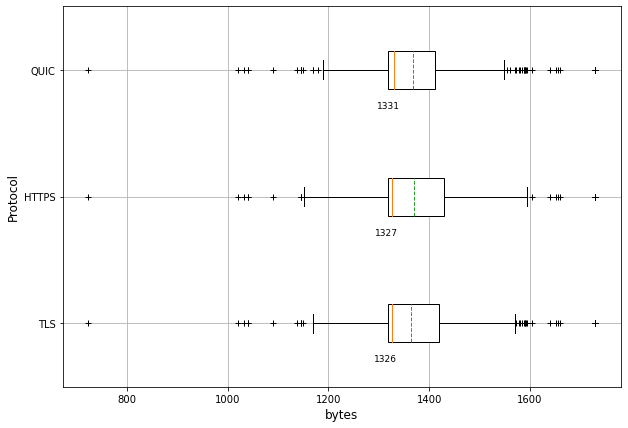

In [46]:
tlsSize = filtered_certs[filtered_certs["protocol"] == "tls"]["size"].tolist()
httpsSize = filtered_certs[filtered_certs["protocol"] == "https"]["size"].tolist()
quicSize = filtered_certs[filtered_certs["protocol"] == "quic"]["size"].tolist()

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([tlsSize, httpsSize, quicSize], vert = 0, sym = "+", patch_artist=True, meanline = True, showmeans = True)
setBoxesWhite(bp)

for median in bp["medians"]:
    x, y = median.get_data()
    ax.text(x[0] - 35, y[0] - 0.15, "{:.0f}".format(x[0]), fontsize = 9, color='black')

ax.set_yticklabels(["TLS", "HTTPS", "QUIC"])

ax.set_xlabel("bytes", fontsize = 12)
ax.set_ylabel("Protocol", fontsize = 12)
plt.grid()

plt.savefig("figures/all_protocol_cert_sizes.pdf", bbox_inches='tight')
plt.show(bp)